# Social Media Data Analysis
### ray zhao

This is a glimpse into how I like to approach data analysis problems and my workflow. I hope it'll be of useful insight to you during the hiring process

In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.3)

## data cleaning and preparation

This is how I loaded and cleaned the data. I renamed the columns to all single-worded keywords that were more clear and succinct, and did the same for the social media platforms. I also created a new `rate`, `day`, and `hour` columns for use in some of the analyses down the line. I also filtered the dataset down to all values within the 1.0 threshold to make the visualizations more scaled.

In [128]:
df = pd.read_excel('data/social_data.xlsx', engine='openpyxl')

new_names = ['date', 'account', 'platform', 'campaign', 'impressions', 'engagements', 'media']
df = df.rename(columns=dict(zip(df.columns, new_names)))

df['rate'] = (df['engagements'] / df['impressions']).fillna(0)
df['posts'] = 1

platform_r = {'fbpage': 'fb', 'tiktok_business': 'tiktok', 'linkedin_company': 'linkedin'}
df['platform'] = df['platform'].str.lower().replace(platform_r)
df['account'] = df['account'].str.lower().str.strip()
df['campaign'] = df['campaign'].str.lower().str.strip()
df['day'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour

df = df[df['rate'] <= 1.0]
df = df.replace({'n/a': np.nan})

## typical engagement

To first get an idea of how our posts and media perform generally, let's first take a look at how our posts across all platforms tend to perform:

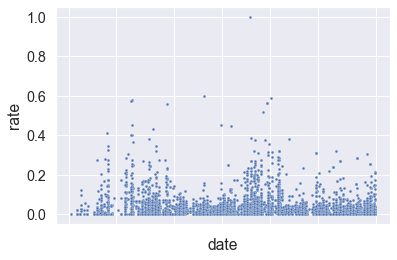

In [130]:
plot = sns.scatterplot(data=df[df['rate'] <= 1.0], x='date', y='rate', s=8).set(xticklabels=[])

While we get a good number of posts above 0.2 and even some over 0.4, we can break all this down to find the average engagement rate of all these posts as well as which percent can shoot above a 15% engagement rate.

In [131]:
print(f"the overall average engagement rate: {np.around(df['rate'].mean(), 2)}")
print(f"the likelihood we achieve a 15% engagement rate: {np.around(((df['rate'] >= 0.15).sum() / df.shape[0]), 2)}")

the overall average engagement rate: 0.04
the likelihood we achieve a 15% engagement rate: 0.06


These statistics get more interesting when we break the numbers down by social media platform. I've highlighted all the posts that broke 15% in green, and we can see how much disparity there is between platforms. Facebook seems to have a sizable plorablity of posts reaching that threshold alongside Instagram with at least some portion, while the others lack a lot of engagement numbers.

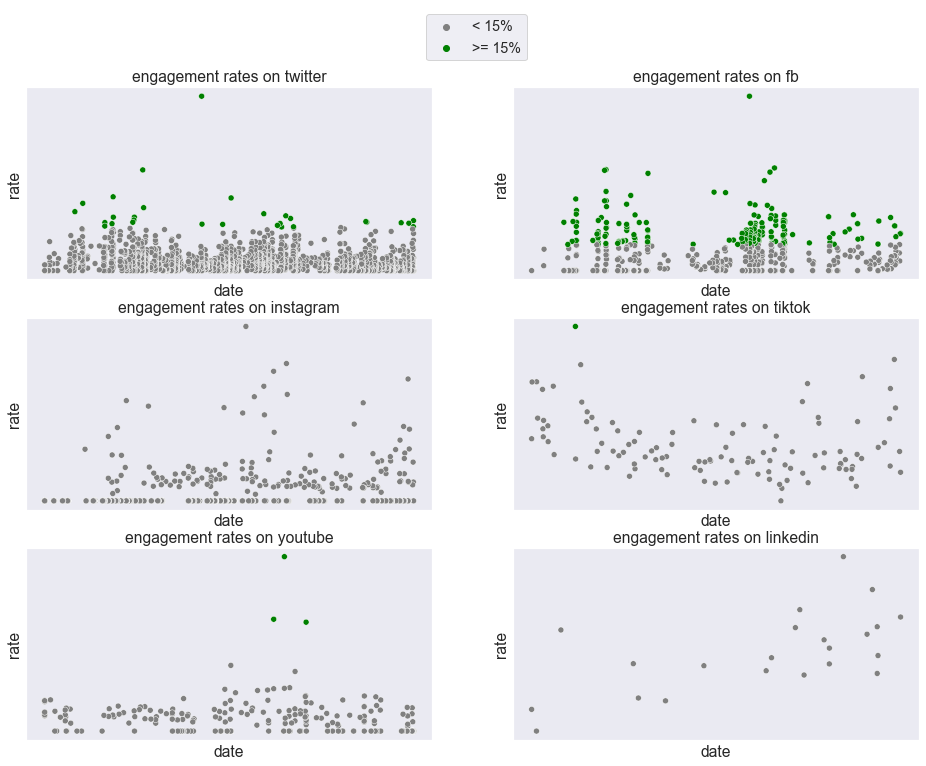

In [145]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()
palette = {'>= 15%': 'green', '< 15%': 'grey'}
for platform, ax in zip(df['platform'].unique(), axes):
	dfd = df[df['platform'] == platform]
	cmap = np.where(dfd['rate'] >= 0.15, '>= 15%', '< 15%')
	plot = sns.scatterplot(data=dfd, x='date', y='rate', hue=cmap, palette=palette, ax=ax)
	axe = ax.get_legend().remove()
	axe = ax.set_title(f"engagement rates on {platform}")
	axe = ax.set_xticks([])
	axe = ax.set_yticks([])
handles, labels = axes[0].get_legend_handles_labels()
fig = fig.legend(handles, labels, loc=(0.46, 0.92))

We can condense and quantify these to compare average engagement rates across platforms:

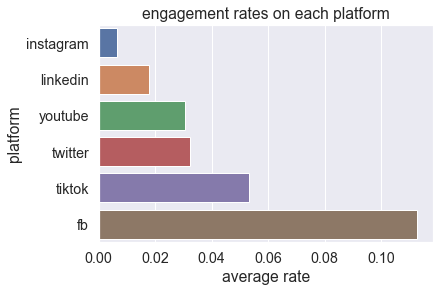

In [133]:
plot = sns.barplot(
    data=df,
    y='platform',
    x='rate',
    order=df.groupby('platform').mean()['rate'].sort_values().reset_index()['platform'],
    ci=None
).set(
    title='engagement rates on each platform',
    xlabel='average rate'
)

We'll explore these numbers and the differences between social channels more in depth a little later, when we determine a posting strategy for our channels.

## across hours and days

For now, let's look at the other metrics and how they coalesce around engagement rates. Here's a visualization of how engagement rates shift through the week for particular days:

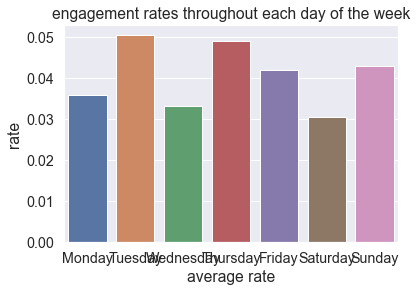

In [135]:
ordering = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot = sns.barplot(
    data=df, x='day', y='rate', order=ordering, ci=None
).set(
    title='engagement rates throughout each day of the week',
    xlabel='average rate'
)

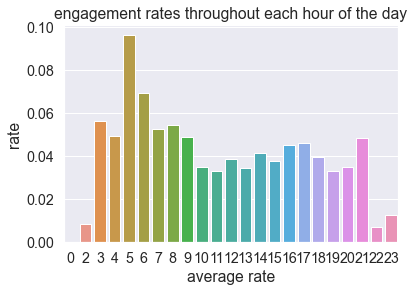

In [136]:
plot = sns.barplot(
    data=df, x='hour', y='rate', ci=None
).set(
    title='engagement rates throughout each hour of the day',
    xlabel='average rate'
)

We can see that content posted on Mondays, Wednesdays, and Saturdays typically perform worse than those posted other days, and that conent posted in the early morning tend to perform the best, with some peaks during lunch and dinner hours.

## game title performance

Here I define some particular metrics of interest that we can use to inform our analysis. To see how our games perform, we need to see how they perform on average in  terms of average impressions, engagements, and engagement rate, but it's also informative for us to look at totals for these metrics as well as how often we post these games. Impressions and engagements are inevitably intertwined with how often a game gets posted, and so we can use those relationships to inform how we approach the average metrics

In [125]:
mean_metrics = ['impressions', 'engagements', 'rate']
total_metrics = ['impressions', 'engagements', 'posts']

def metric_board(df, cat, labels=True, ordered=False):
	fig, axes = plt.subplots(2, 3, figsize=(16, 10))
	for ax, metric in zip(axes[0], total_metrics):
		if ordered:
			plot = sns.barplot(
						data=df,
						y=metric,
						x=cat,
						estimator=sum,
						order=df.groupby(cat).sum()[metric].sort_values().reset_index()[cat],
						ci=None,
						ax=ax
                    ).set(ylabel=f"total {metric}")
		else:
			plot = sns.barplot(data=df, y=metric, x=cat, estimator=sum, ci=None, ax=ax).set(ylabel=f"total {metric}")
		if labels:
			axe = ax.bar_label(ax.containers[0])

	for ax, metric in zip(axes[1], mean_metrics):
		if ordered:
			plot = sns.barplot(
						data=df,
						y=metric,
						x=cat,
						order=df.groupby(cat).mean()[metric].sort_values().reset_index()[cat],
						ci=None,
						ax=ax
                    ).set(ylabel=f"average {metric}")
		else:
			plot = sns.barplot(data=df, y=metric, x=cat, ci=None, ax=ax).set(ylabel=f"average {metric}")
		if labels:
			axe = ax.bar_label(ax.containers[0])

	title = fig.suptitle('total + average metrics')

	return fig

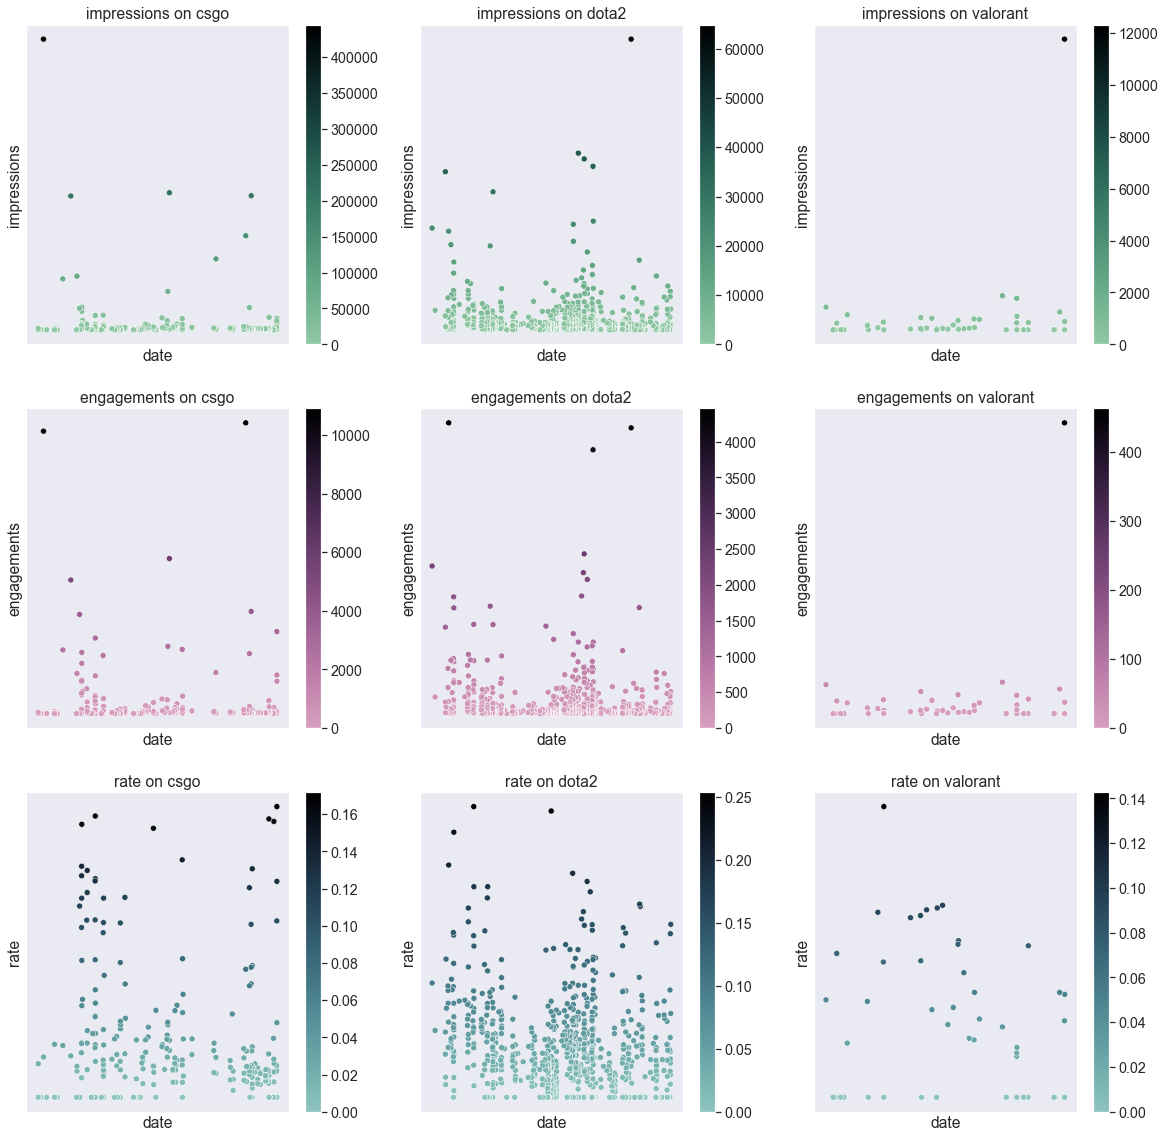

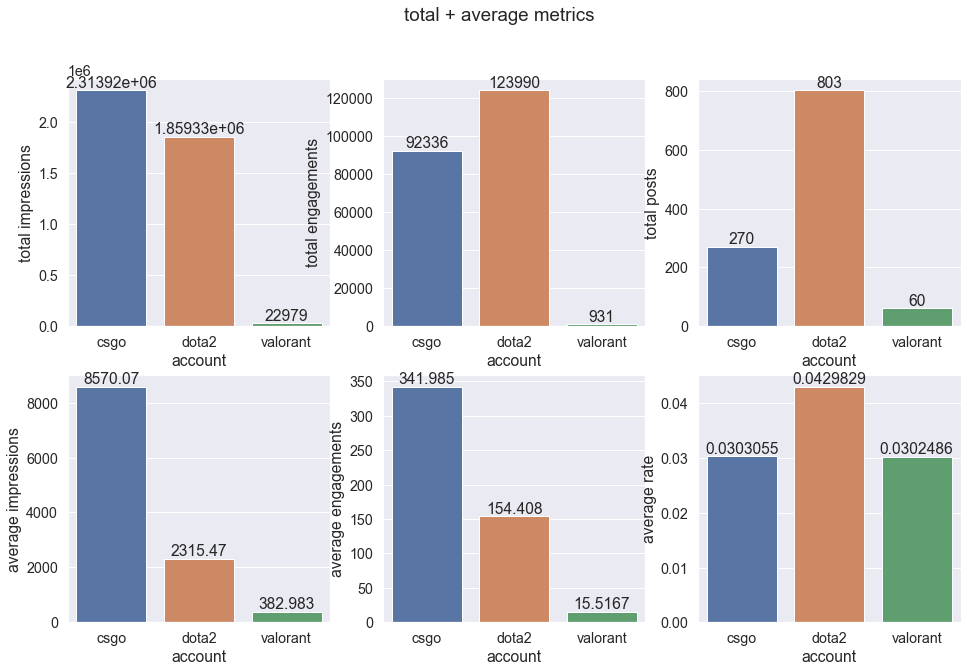

In [194]:
games = ['csgo', 'dota2', 'valorant']
cmappings = (-0.5, 0.2), (0.2, -0.2), (-0.2, 0.2)
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for x_ax, metric, cmapping in zip(axes, mean_metrics, cmappings):
	cmap = sns.cubehelix_palette(start=cmapping[0], rot=-cmapping[1], dark=0, light=0.7, as_cmap=True)
	for game, ax in zip(games, x_ax):
		dfd = df[df['account'] == game]
		plot = sns.scatterplot(data=dfd, x='date', y=metric, hue=metric, palette=cmap, ax=ax)
		norm = plt.Normalize(dfd[metric].min(), dfd[metric].max())
		sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
		axe = ax.get_legend().remove()
		axe = ax.figure.colorbar(sm, ax=ax)
		axe = ax.set_title(f"{metric} on {game}")
		axe = sm.set_array([])
		axe = ax.set_xticks([])
		axe = ax.set_yticks([])

dfd = df[df['account'].isin(games)]
gamedf = df[df['account'].isin(games)]
plot = metric_board(dfd, 'account')

CSGO dominantes average impressions and engagements per post but DOTA actually performs the best for engagement rates, which is both impressive given and likely a result of how much more content it gets compared to CSGO and Valorant. And even though Valorant has the smallest average raw numbers and gets posted 13x less than DOTA and 4x less than CSGO, it holds relatively equal to CSGO on engagement rates. Valorant definitely seems like an area where we could focus more. CSGO and DOTA are both somewhat aging properties, and Valorant is a relatively new IP with a lot of ceiling for growth, which seems currently underleveraged.

## performance across media

Now let's take a look at how we perform across different types of media on an average basis across all platforms:

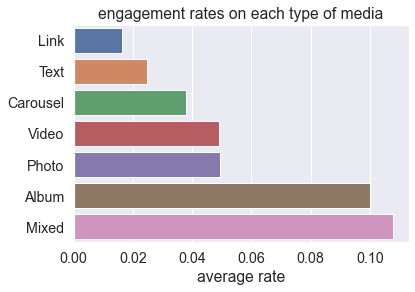

In [87]:
plot = sns.barplot(
    data=df, y='media', x='rate', order=df.groupby('media').mean()['rate'].sort_values().reset_index()['media'], ci=None
).set(
    title='engagement rates on each type of media',
    ylabel=None,
    xlabel='average rate'
)

At first glance, albums and mixed media come out on top, with photos and videos coming in almost equally at 3rd and 4th

This is a relatively naive way to approach this problem. Obviously text posts won't be receiving the most engagemets on an app like Youtube, so seeing patterns of engagement on each platform is illuminating.

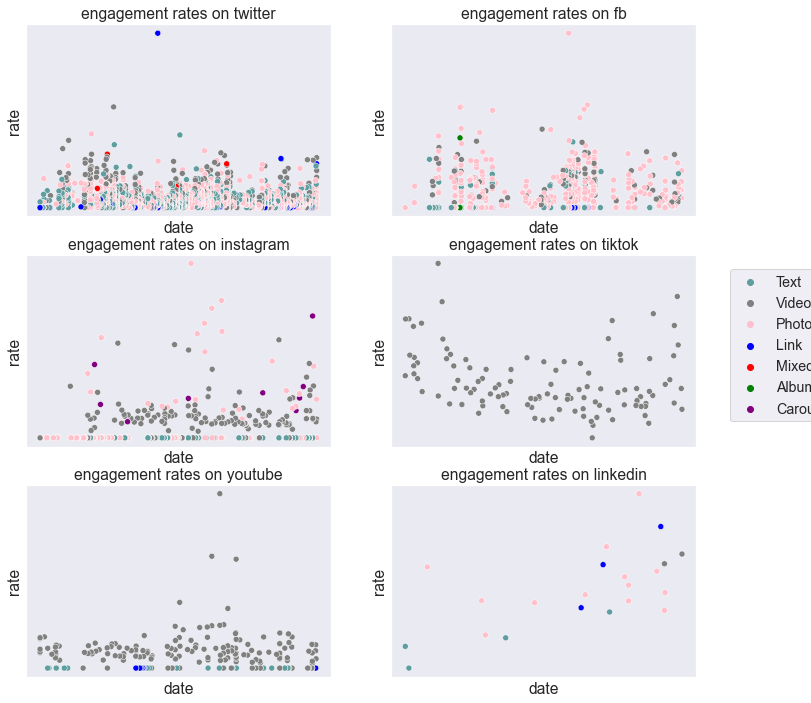

In [137]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

medias = df['media'].unique()
colors = ['cadetblue', 'grey', 'pink', 'blue', 'purple', 'red', 'green']
palette = dict(zip(medias, colors))

for platform, ax in zip(df['platform'].unique(), axes):
	dfd = df[df['platform'] == platform]
	plot = sns.scatterplot(data=dfd, x='date', y='rate', hue='media', palette=palette, ax=ax)
	axe = ax.get_legend().remove()
	axe = ax.set_title(f"engagement rates on {platform}")
	axe = ax.set_xticks([])
	axe = ax.set_yticks([])

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels, lines = zip(*dict(zip(labels, lines)).items())
fig = fig.legend(lines, labels, loc=(0.9, 0.4))

Here we can spot some interesting patterns in how photo and video tend to dominate (on certain platforms), as well as spot some outliers. Mixed media and albums perform well but are also not at all the bread and butter of the primary social channels, wich seem to very, very densely populated by more idiomatic emdiums like photos and video.
 To figure out the best type of media for each platform, we can aggregate these numbers by platform as such:

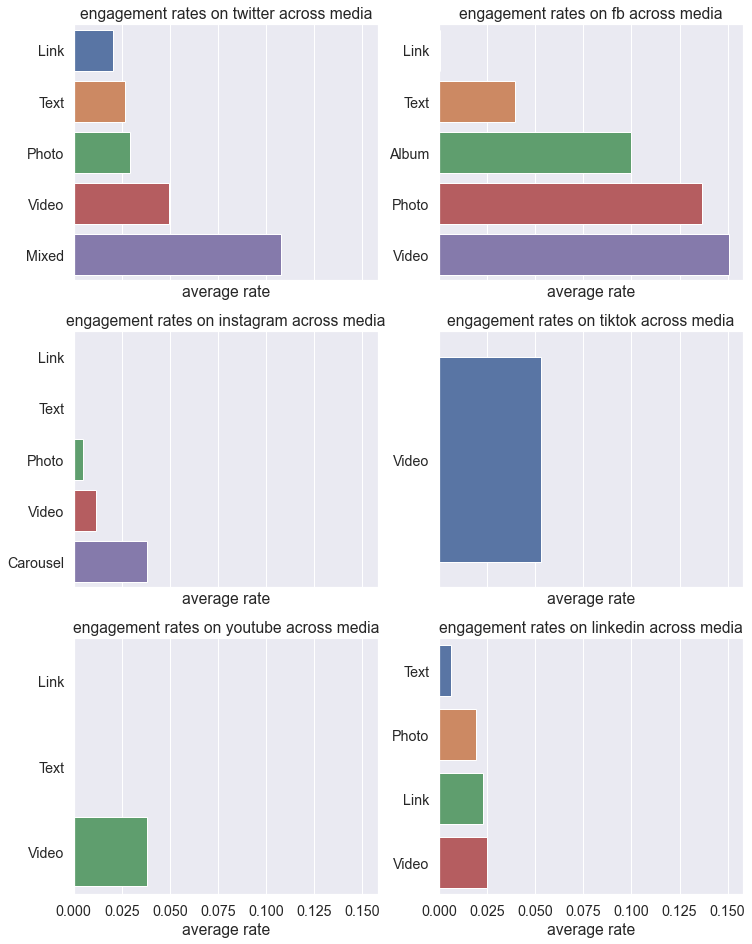

In [138]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16), sharex=True)
axes = axes.flatten()

for platform, ax in zip(df['platform'].unique(), axes):
	dfd = df[df['platform'] == platform]
	plot = sns.barplot(data=dfd, y='media', x='rate', order=dfd.groupby('media').mean()['rate'].sort_values().reset_index()['media'], ci=None, ax=ax)
	axe = ax.set_title(f"engagement rates on {platform} across media")
	axe = ax.set(ylabel=None)
	axe = ax.set(xlabel='average rate')

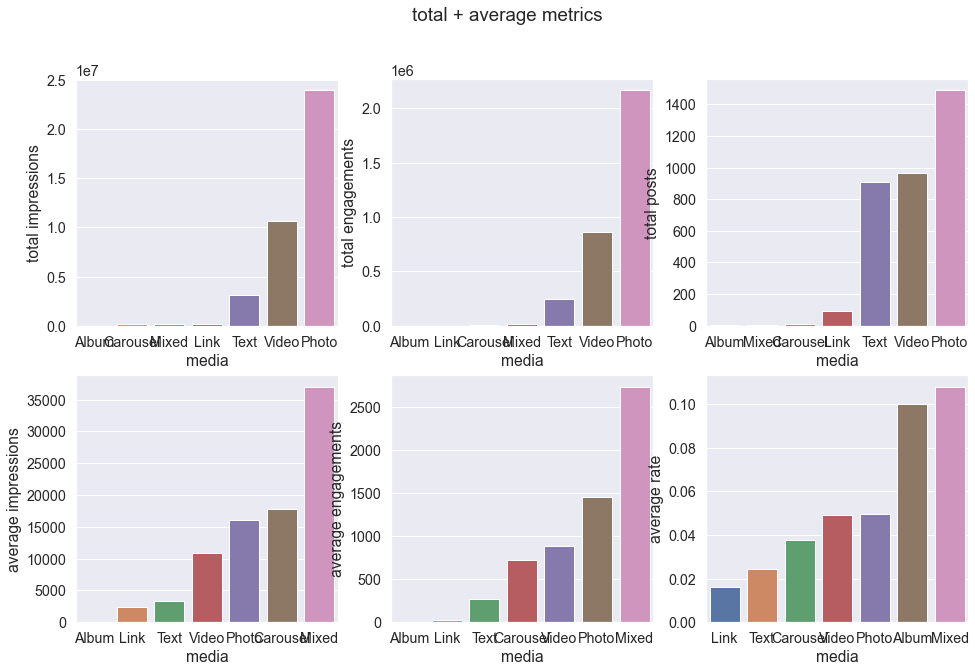

In [139]:
plot = metric_board(df, 'media', labels=False, ordered=True)

So while carousels and albums seemed the best on initial glance, it seems like videos and photos still dominante across platforms, with mixed media on Twitter, video on Facebook, and carousels on Instagram being of particular note. 
That being said, photos still tend to perform best in terms of total and average impressions and engagements, with the average metric numbers taking into account the fact that photos tend to get posted much more.
Overall, it seems like video performs the best across all platforms.

## campaign performance

We can break down our campaign performance in the same way we did for our games:

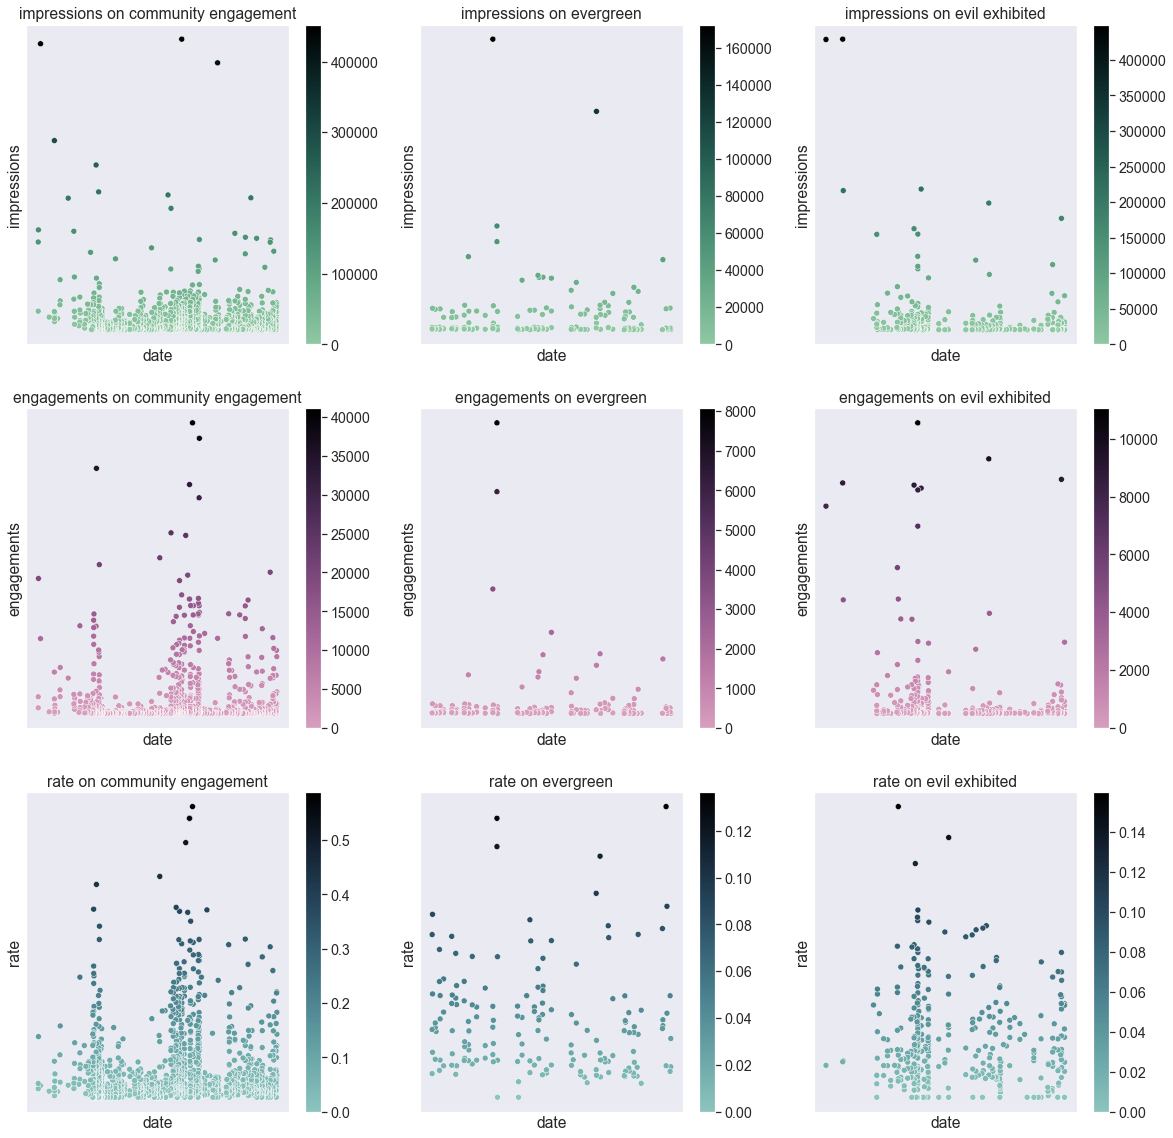

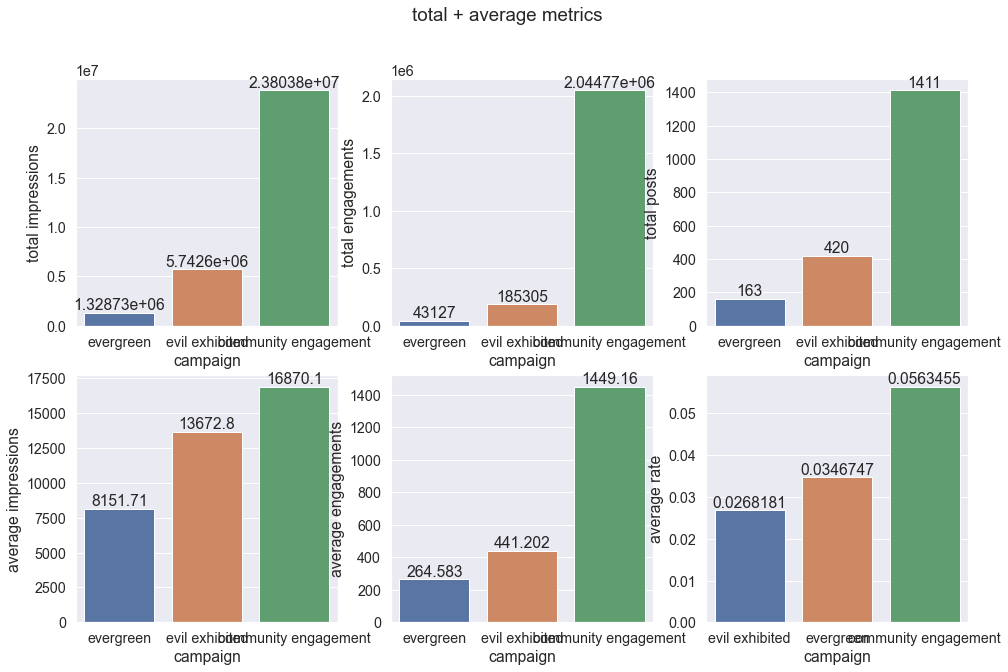

In [140]:
campaigns = df['campaign'].dropna().unique()
metrics = ['impressions', 'engagements', 'rate']
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
cmappings = (-0.5, 0.2), (0.2, -0.2), (-0.2, 0.2)
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for x_ax, metric, cmapping in zip(axes, metrics, cmappings):
	cmap = sns.cubehelix_palette(start=cmapping[0], rot=-cmapping[1], dark=0, light=0.7, as_cmap=True)
	for campaign, ax in zip(campaigns, x_ax):
		dfd = df[df['campaign'] == campaign]
		plot = sns.scatterplot(data=dfd, x='date', y=metric, hue=metric, palette=cmap, ax=ax)
		norm = plt.Normalize(dfd[metric].min(), dfd[metric].max())
		sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
		axe = sm.set_array([])
		axe = ax.get_legend().remove()
		axe = ax.figure.colorbar(sm, ax=ax)
		axe = ax.set_title(f"{metric} on {campaign}")
		axe = ax.set_xticks([])
		axe = ax.set_yticks([])

dfd = df[df['campaign'].isin(campaigns)]
plot = metric_board(dfd, 'campaign', ordered=True)

We can see that community development gets a lot of love; the most posts, impressions, and engagement. Aside from that though, even while evil exhibited gets the second most posts, impressions, and engagement, evergreen actually outperformed it in terms of engagement rate, while evil exhibited still gets more impressions and engagements on average.

## the social channel strategy

To figure out a good strategy for posting, we'll need to figure out our strengths and weaknesses, to ascertain what's been working and what needs improving. Let's start with looking at when we post, and how often we do it:

The nature of social media algorithms tends to favor frequency, so when we evaluate engagement rates it also helps to see them relative to the frequency of the content we're evaluating engagement rates on. We can make a engagement coefficient by dividing engagement rates by total post count multipled by 10000 to give us a nice whole-ish number that we can easily use to find value and help determine efficiency. Think of it as a "second derivative" for engagement figures. Naturally, this is a correlative and not causative symtpom. We can't draw hard conclusions about if frequency causes high engagement or high engagement begets frequency, but we can use it to observe when these two move together and to help guide intuitive heuristics about posting. Posting after all, is more art than science, so let's give ourselves a cool new brush.

### when

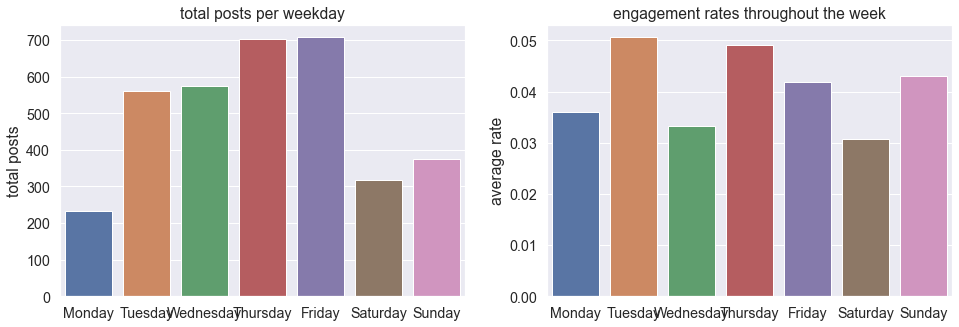

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot = sns.barplot(
    data=df,
    x='day',
    y='posts',
    estimator=sum,
    order=ordering,
    ci=None,
    ax=axes[0]
).set(
    title='total posts per weekday',
    xlabel=None,
    ylabel='total posts'
)
plot = sns.barplot(
    data=df, x='day', y='rate', order=ordering, ci=None, ax=axes[1]
).set(
    title='engagement rates throughout the week',
    ylabel='average rate',
    xlabel=None
)

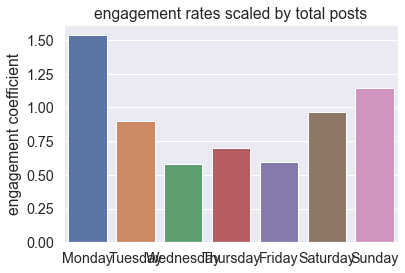

In [181]:
plot = sns.barplot(
    data=df,
    x='day',
    y='rate',
	estimator=lambda x: np.mean(x) / len(x) * 10000,
    order=ordering,
    ci=None,
).set(
    title='engagement rates scaled by total posts',
    ylabel='engagement coefficient',
    xlabel=None
)

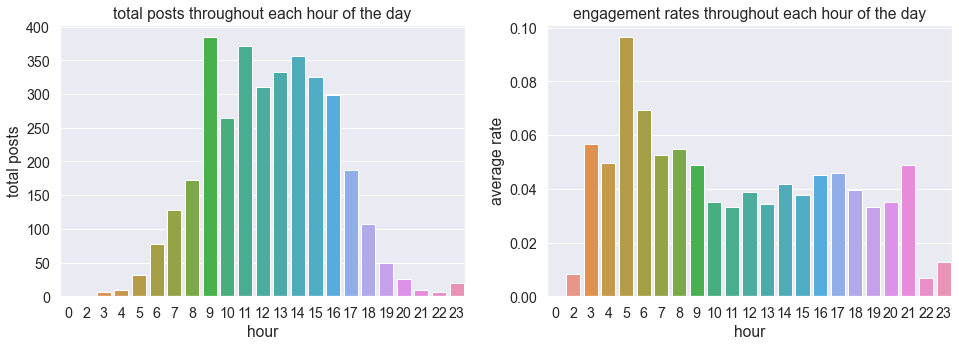

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot = sns.barplot(
    data=df, x='hour', y='posts', estimator=sum, ci=None, ax=axes[0]
).set(
    title='total posts throughout each hour of the day',
    ylabel='total posts'
)
plot = sns.barplot(
    data=df, x='hour', y='rate', ci=None, ax=axes[1]
).set(
    title='engagement rates throughout each hour of the day',
    ylabel='average rate'
)

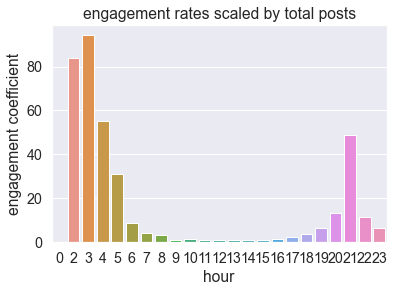

In [183]:
plot = sns.barplot(
    data=df,
    x='hour',
    y='rate',
	estimator=lambda x: np.mean(x) / len(x) * 10000,
    ci=None,
).set(
    title='engagement rates scaled by total posts',
    ylabel='engagement coefficient',
)

We can see pretty immediately that the distribution on which we post (almost Gaussian) clearly doesn't match how our performances typically stay flat wit a slight tail. Now, of course we can't immediately shift all posting to 5am on Thursdays and Fridays, but this does seem to suggest that for posts with not as strict posting windows (like more social content as opposed to corporate announcements) we can definitely experiment with a flatter, right tailed distribution that biases earlier posting on a wider variety of weekdays, especially Monday. Our engagement coefficients confirm this, with Monday and the early mornings featuring prominently.

### where

Now that we've figured out when we should try to post more, how about where? We can segment this data into social channels:

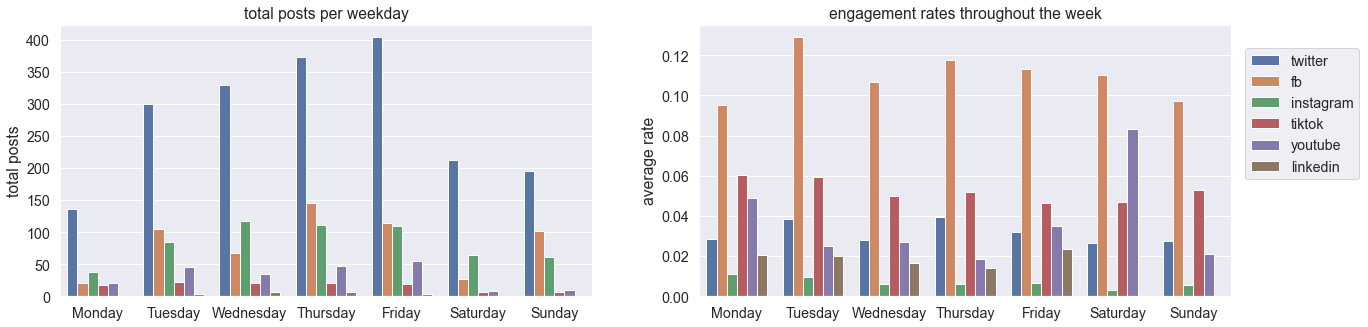

In [184]:
fig, axes = plt.subplots(1, 2, figsize=(21, 5))
plot = sns.barplot(
    data=df,
    x='day',
    y='posts',
    hue='platform',
    estimator=sum,
    order=ordering,
    ci=None,
    ax=axes[0]
).set(
    title='total posts per weekday',
    xlabel=None,
    ylabel='total posts'
)
plot = sns.barplot(
    data=df,
    x='day',
    y='rate',
    hue='platform',
    order=ordering,
    ci=None,
    ax=axes[1]
).set(
    title='engagement rates throughout the week',
    ylabel='average rate',
    xlabel=None
)
axe = [ax.get_legend().remove() for ax in axes]
handles, labels = axes[0].get_legend_handles_labels()
fig = fig.legend(handles, labels, loc=(0.91, 0.45))

We see really consistent patterns in both posting and responses, with some notable elements including how Youtube spikes dramatically on Saturdays and TikTok seemingly consistently outperforming other platforms relative to how much we post to it. This is also (but slightly less so) for Facebook, which outperforms in engagement relative to how much content it gets.

This all makes a lot of sense. Facebook and TikTok might naturally get a lot more interesting and interactive content, with Twitter and Instagram mainly acting as newsletters for the company.

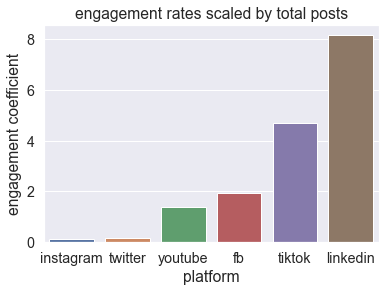

In [ ]:
plot = sns.barplot(
    data=df,
    x='platform',
    y='rate',
	estimator=lambda x: np.mean(x) / len(x) * 10000,
    order=df.groupby('platform')['rate'].apply(lambda x: np.mean(x) / len(x)).sort_values().reset_index()['platform'],
    ci=None,
).set(
    title='engagement rates scaled by total posts',
    ylabel='engagement coefficient',
)

The engagement coefficients confirm this, with TikTok commanding its space and LinkedIn, surprinsgly, giving the most apparent bang for buck. I'm sure marketing more to the eager minded professionals on LinkedIn certainly wouldn't hurt, it's also not really the main market demographic or ideal social platform for Evil Geniuses. This points to TikTok being a severely underleveraged asset for our social channels, reaffirmed by the fact that it is arguably the fastest growing platform of all the social channels.

### what

Having explored when and where to post, let's talk about what to post. This decomposes into 2 main components: which games and which types of media. Let's explore the media channels first:

We already found out earlier that photos and video dominate, with mixed media and carousels crowning their respective exclusive platforms but videos and photos otherwise staying across other channels. Let's now look at the coefficients:

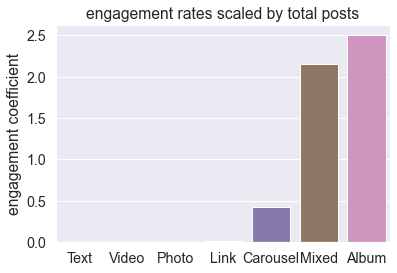

In [193]:
plot = sns.barplot(
    data=df,
    x='media',
    y='rate',
	estimator=lambda x: np.mean(x) / len(x) * 100,
    ci=None,
).set(
    title='engagement rates scaled by total posts',
    ylabel='engagement coefficient',
    xlabel=None
)

Mixed media, albums, and carousels come out on top here but they evidently are the most resource intense posts, usually reserved for bigger occasions and content that would naturally attract more engagement.

In terms of games, we found earlier how Valorant really was another underleveraged property and we can confirm it here:

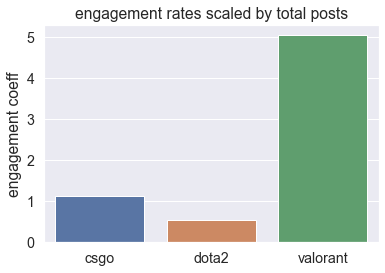

In [199]:
plot = sns.barplot(
    data=gamedf,
    x='account',
    y='rate',
	estimator=lambda x: np.mean(x) / len(x) * 10000,
    ci=None,
).set(
    title='engagement rates scaled by total posts',
    ylabel='engagement coeff',
    xlabel=None
)

Valorant gets almost 5x the value of CSGO, which present a big opportunity for expansion into the space.

### the social channel strategy takeaways

1. Post earlier in the day, but the day selection doesn't seem to matter too much (except for Mondays, post more on Mondays)

2. Facebook provides great engagement, but TIkTok is a truly underleveraged space. Post more on TikTok!

3. Focus on quality photo and video content, and try to push more into Valorant.

TLDR: __Post more Valorant TikToks earlier in the morning earlier in the week!__